In [77]:
'''
possible ideas for the project: 

- Graph drinks, drugs
- linear regression for all of them


- See if naive bayes can predict what someome's attributes are from their essays 
(use q3 of essays to predict body type, use q7 to predict drinking/drug habits, q1 to predict education)
- try to find the person most like a set of answers being put in 
(maybe use bayes to find similarity index for essays)
- k means grouping of people in multiple choice to see if there are any groups
- decision forest for what attributes make people single (choose a few)
'''

"\npossible ideas for the project: \n\n- Graph drinks, drugs\n- linear regression for all of them\n\n\n- See if naive bayes can predict what someome's attributes are from their essays \n(use q3 of essays to predict body type, use q7 to predict drinking/drug habits, q1 to predict education)\n- try to find the person most like a set of answers being put in \n(maybe use bayes to find similarity index for essays)\n- k means grouping of people in multiple choice to see if there are any groups\n- decision forest for what attributes make people single (choose a few)\n"

In [392]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt


profiles = pd.read_csv('profiles.csv')

In [393]:
#checking what the dataset looks like
print(len(profiles.index))
print(profiles.dtypes)
profiles.head()
profiles_vis = profiles

59946
age              int64
body_type       object
diet            object
drinks          object
drugs           object
education       object
essay0          object
essay1          object
essay2          object
essay3          object
essay4          object
essay5          object
essay6          object
essay7          object
essay8          object
essay9          object
ethnicity       object
height         float64
income           int64
job             object
last_online     object
location        object
offspring       object
orientation     object
pets            object
religion        object
sex             object
sign            object
smokes          object
speaks          object
status          object
dtype: object


In [394]:
#cleaning up essay and offspring columns
profiles.iloc[0][['essay0', 'offspring']]
for i in profiles.columns:
    if profiles[i].dtype == 'object':
        profiles[i] = profiles[i].str.replace(pat = '<br />\n', repl = '')
        profiles[i] = profiles[i].str.replace(pat = '&rsquo;', repl = '\'')
profiles.head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:i would love to think that i was some...,currently working as an international agent fo...,making people laugh.ranting about a good salti...,"the way i look. i am a six foot half asian, ha...",...,"south san francisco, california","doesn't have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.1. i am a...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,...,"oakland, california","doesn't have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,...,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn't matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,...,"berkeley, california",doesn't want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:http://bagsbrown.b...,i smile a lot and my inquisitive nature,...,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


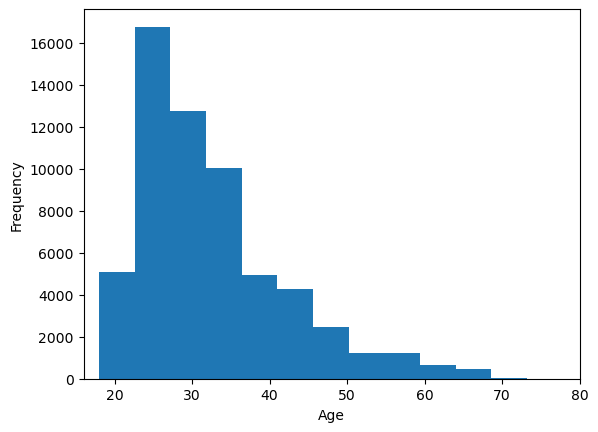

In [395]:
#Age Histogram
plt.hist(profiles.age, bins=20)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.xlim(16, 80)
plt.show()

In [396]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
inputs = ['diet_num', 'drinks_num', 'drugs_num', 'smokes_num', 'height_num', 'income_num']
mapper_diet = {'anything':0, 'mostly':1, 'strictly':3, 'vegetarian':2, 'vegan':2, 'halal':2, 'kosher':2, 'other':2}
mapper_drinks = {'not at all':0, 'rarely':1, 'socially':2, 'very often':4, 'often':3, 'desperately':5}
mapper_drugs = {'never':0, 'sometimes':1, 'often':2}
mapper_smokes = {'no':0, 'sometimes':1, 'when drinking':2, 'trying to quit':3, 'yes':4}
profiles['diet_num'] = profiles['diet'].replace(regex = mapper_diet)
profiles['drinks_num'] = profiles['drinks'].map(mapper_drinks)
profiles['drugs_num'] = profiles['drugs'].map(mapper_drugs)
profiles['smokes_num'] = profiles['smokes'].map(mapper_smokes)
profiles['height_num'] = profiles['height']
profiles['income_num'] = profiles['income']

In [397]:
for i in inputs:
    scld = np.array(profiles[i]).reshape(-1,1)
    mm_scaler.fit(scld)
    profiles[i] = mm_scaler.transform(scld)
profile_metrics = []
for j in range(len(profiles.index)):
    user = []
    for k in inputs:
        user.append(profiles[k].iloc[j])
    profile_metrics.append(user)  

#Quantify drinks, drugs, smoking
profiles['substances'] = profiles['drinks_num'] + profiles['smokes_num'] + profiles['drugs_num']

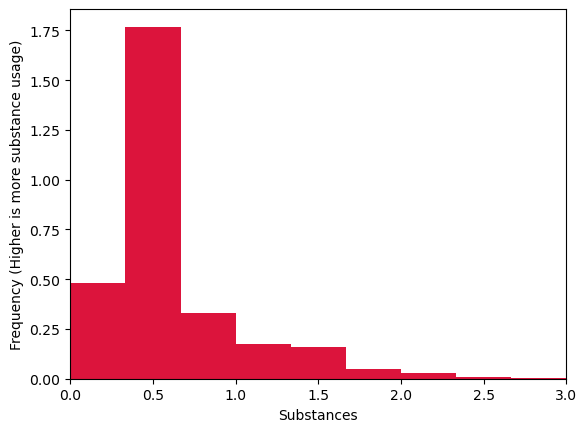

In [398]:
plt.hist(profiles.substances, bins=9, density = True, color = 'crimson')
plt.xlabel("Substances")
plt.ylabel("Frequency (Higher is more substance usage)")
plt.xlim(0, 3)
plt.show()
#Seems like the lion's share of numbers at 2 come from no drugs or smoking and social drinking, with the second
#spike being from 2 in drinking, smoking and drugs (social drinking with smoking, some drugs)

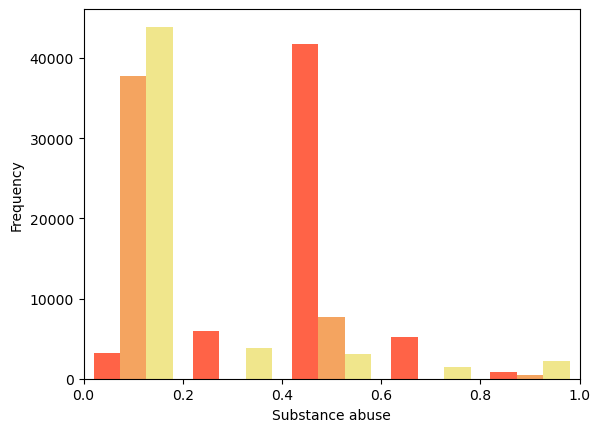

In [399]:
#Drinking, Smoking, Drugs Histogram
plt.hist([profiles.drinks_num, profiles.drugs_num, profiles.smokes_num], bins=5, color = ['tomato', 'sandybrown', 'khaki'])
plt.xlabel("Substance abuse")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.show()

[]

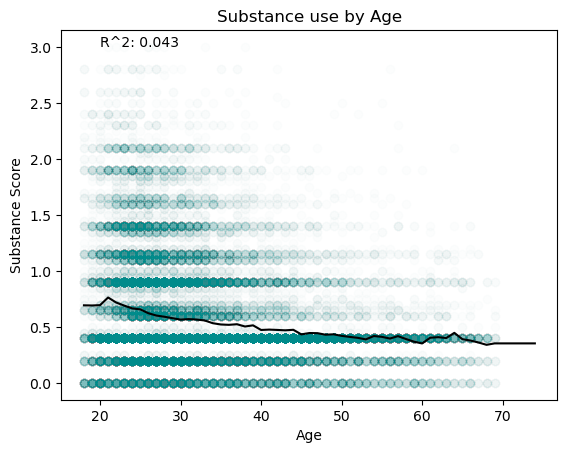

In [400]:
profiles = profiles.dropna(subset = ['substances', 'age'])
plt.scatter(profiles.age, profiles.substances, alpha = .01, color = 'darkcyan')
lr = RandomForestRegressor()
x_form = np.array(profiles.age).reshape(-1,1)
y_form = np.array(profiles.substances)
lr.fit(x_form, y_form)
age_base = [i for i in range(18,75)]
y_pred = lr.predict(np.array(age_base).reshape(-1,1))
plt.plot(age_base, y_pred, color = 'black')
plt.xlabel('Age')
plt.ylabel('Substance Score')
score = lr.score(x_form, y_form)
plt.annotate('R^2: {:.3f}'.format(score), (20, 3))
plt.title('Substance use by Age')
plt.plot()